In [122]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')
import gradio as gr

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CSVReadExample").getOrCreate()
import findspark
findspark.init()

In [123]:
# Read the CSV file into a DataFrame and limit rows to 250,000
csv_file_path = "Resources/card_transdata.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)
df = df.limit(250000)


 #Show the first few rows of the DataFrame
df.show()

df.count()

+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
|distance_from_home|distance_from_last_transaction|ratio_to_median_purchase_price|repeat_retailer|used_chip|used_pin_number|online_order|fraud|
+------------------+------------------------------+------------------------------+---------------+---------+---------------+------------+-----+
| 57.87785658389723|            0.3111400080477545|            1.9459399775518593|            1.0|      1.0|            0.0|         0.0|  0.0|
|10.829942699255545|           0.17559150228166587|            1.2942188106198573|            1.0|      0.0|            0.0|         0.0|  0.0|
| 5.091079490616996|            0.8051525945853258|           0.42771456119427587|            1.0|      0.0|            0.0|         1.0|  0.0|
|2.2475643282963613|              5.60004354707232|           0.36266257805709584|            1.0|      1.0|            0.0|         1.0

250000

Imbalance ratio: 10.52


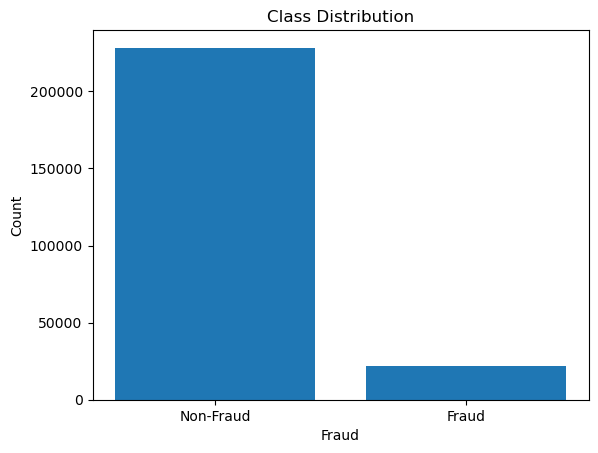

Imbalance ratio: 10.52


In [124]:
# Calculate class distribution
class_distribution = df.toPandas()
class_distribution
class_distribution = class_distribution['fraud'].value_counts()
# Calculate imbalance ratio
imbalance_ratio = class_distribution[0] / class_distribution[1]

print(f"Imbalance ratio: {imbalance_ratio:.2f}")


# Create a bar chart to visualize class distribution
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(class_distribution.index, ['Non-Fraud', 'Fraud'])
plt.show()

print(f"Imbalance ratio: {imbalance_ratio:.2f}")




In [125]:
# since the ratio is significantly larger than 1, it indicates an imbalanced dataset, where the majority class (non-fraud) has a much larger representation than the minority class (fraud).

In [126]:
#Exploratory Data Analysis

eda_df =  df.toPandas().copy()

In [127]:
# normalize data
scaler_eda = MinMaxScaler()
eda_df[eda_df.columns] = scaler_eda.fit_transform(eda_df)
eda_df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0.012575,0.000117,0.007280,1.0,1.0,0.0,0.0,0.0
1,0.002349,0.000066,0.004836,1.0,0.0,0.0,0.0,0.0
2,0.001102,0.000302,0.001587,1.0,0.0,0.0,1.0,0.0
3,0.000484,0.002102,0.001343,1.0,1.0,0.0,1.0,0.0
4,0.009600,0.000213,0.008318,1.0,1.0,0.0,1.0,0.0


In [128]:
# find the average
#eda_df = eda_df.groupby("fraud").mean()
dfgr = df.toPandas().groupby("fraud").mean()
dfgr


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
fraud,,,,,,,
0.0,22.906293,4.263432,1.419572,0.881798,0.360380,0.111233,0.624446
1.0,66.381046,12.515710,5.982629,0.881594,0.255563,0.003225,0.948076


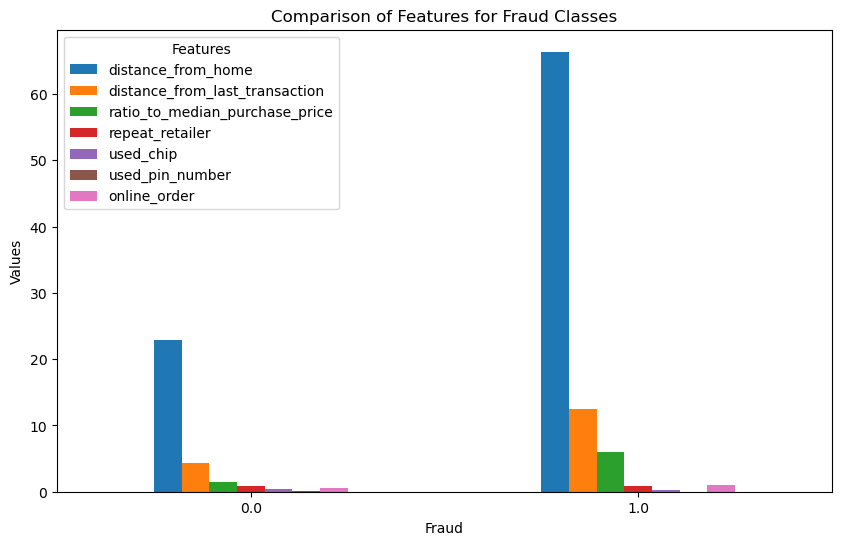

In [129]:
dfgr.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Fraud')
plt.ylabel('Values')
plt.title('Comparison of Features for Fraud Classes')
plt.xticks(rotation=0)
plt.legend(title='Features')
plt.show()

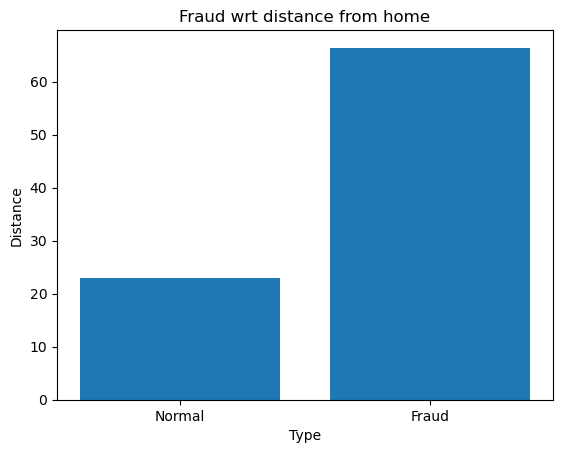

In [130]:
plt.title("Fraud wrt distance from home")
plt.bar(["Normal","Fraud"],dfgr["distance_from_home"])
plt.xlabel("Type")
plt.ylabel("Distance")
plt.show()

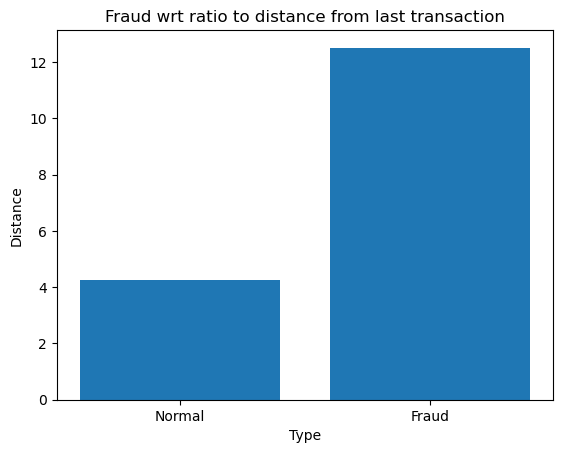

In [131]:
plt.title("Fraud wrt ratio to distance from last transaction")
plt.bar(["Normal","Fraud"],dfgr["distance_from_last_transaction"])
plt.xlabel("Type")
plt.ylabel("Distance")
plt.show()


In [132]:
# The probability of fraud spikes as the distance from home and last transaction increases.

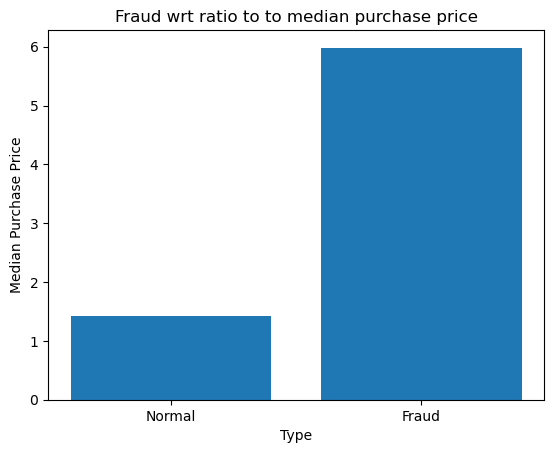

In [133]:
plt.title("Fraud wrt ratio to to median purchase price")
plt.bar(["Normal","Fraud"],dfgr["ratio_to_median_purchase_price"])
plt.xlabel("Type")
plt.ylabel("Median Purchase Price")
plt.show()



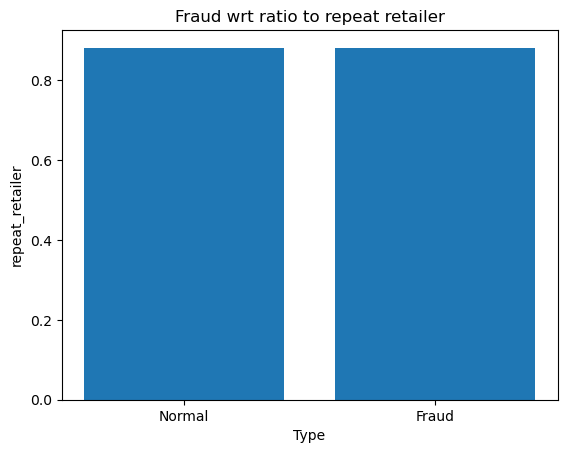

In [134]:
plt.title("Fraud wrt ratio to repeat retailer")
plt.bar(["Normal","Fraud"],dfgr["repeat_retailer"])
plt.xlabel("Type")
plt.ylabel("repeat_retailer")
plt.show()

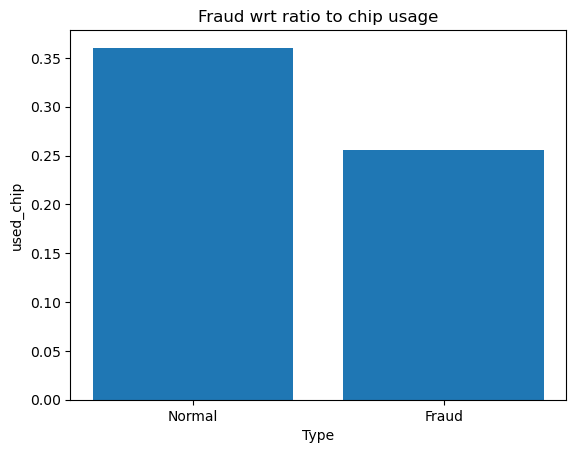

In [135]:
plt.title("Fraud wrt ratio to chip usage")
plt.bar(["Normal","Fraud"],dfgr["used_chip"])
plt.xlabel("Type")
plt.ylabel("used_chip")
plt.show()

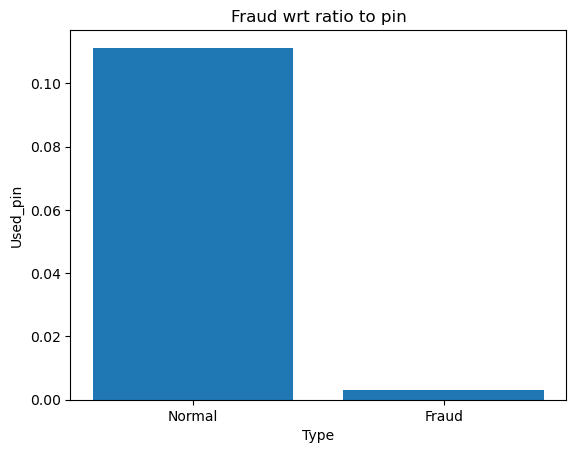

In [136]:
plt.title("Fraud wrt ratio to pin")
plt.bar(["Normal","Fraud"],dfgr["used_pin_number"])
plt.xlabel("Type")
plt.ylabel("Used_pin")
plt.show()

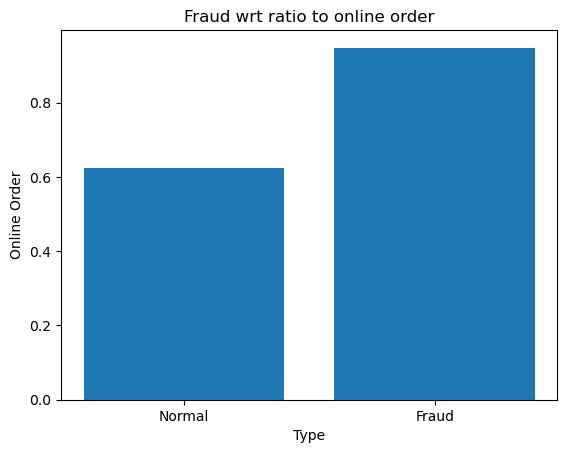

In [137]:
plt.title("Fraud wrt ratio to online order")
plt.bar(["Normal","Fraud"],dfgr["online_order"])
plt.xlabel("Type")
plt.ylabel("Online Order")
plt.show()

In [138]:
# The above graph reveals that repeat retailer, pin and chip usage don't affect the probability of a transaction being fraud while the online orders are more likely to be fraudulent.